# MLE for phase shifts
This document explains the likelihood function for our data, as a function of a phase shift applied to the source signal. 

In [401]:
import matplotlib.pyplot as plt
import numpy as np
#from scipy.fftpack import *
import scipy.optimize
import itertools
import numba
from numba import jit, njit
from multiprocessing import Pool

from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [402]:
mppool = Pool(16)

In [403]:
sampleFreq = 48
Tmax = 2

N = int(Tmax*sampleFreq)
T = np.array([float(i)/sampleFreq for i in range(N)])
Tmax = float(N)/sampleFreq

The source signal is a superposition of $n$ sinusoid waves. Suppose that for each $i$th wave, we have its frequency $f_i$, phase shift $\phi_i$ and amplitude $A_i$. The source signal at $t$ is then:
$$X(t) = \sum_{i=1}^{n} A_i \sin(2\pi(t*f_i + \phi_i))$$
Since only the frequencies are known in this experiment, but the phase shifts and amplitudes are not, we write:
$$X(t,\pmb{\phi},\pmb{A}) = \sum_{i=1}^{n} A_i \sin(2\pi(t*f_i + \phi_i))$$

where $\pmb{\phi}=(\phi_1,\dots,\phi_n)^T$ and $\pmb{A}=(A_1,\dots,A_n)^T$ are the vectors of phase shifts and amplitudes of each wave, respectively. 

In [457]:
sourceFreqs = np.array([4.77, 1.654321])
maxAmplitude = 10.0

n = len(sourceFreqs)

@njit
def sourceFunc(t, sourcePhases, sourceAmplitudes):
    """
    if len(sourceFreqs) != len(sourcePhases):
        raise ValueError('Number of source frequencies does not number of source phases')
    if len(sourceFreqs) != len(sourceAmplitudes):
        raise ValueError('Number of source frequencies does not number of source amplitudes')
    """
    #tGrid,phaseGrid=np.meshgrid(t,sourcePhases)
    tCol = np.reshape(t,(-1,1))#t[:,np.newaxis]
    sfRow = np.reshape(sourceFreqs,(1,-1))#sourceFreqs[np.newaxis,:]
    saCol = np.reshape(sourceAmplitudes,(-1,1))
    return np.dot(np.sin((np.dot(tCol,sfRow)+sourcePhases)*2.0*3.14159265358979323846264),saCol).flatten()
    
    #return np.dot(np.reshape(sourceAmplitudes,(1,2)), np.sin((np.dot(np.diag(sourceFreqs),tGrid)+phaseGrid)*2.0*np.pi)).flatten()
    
    #return sum(ampl*np.sin((t * freq + phase)*2.0*np.pi) for freq,phase,ampl in zip(sourceFreqs,sourcePhases,sourceAmplitudes))

Let's simulate a measurement by evaluating the source function with random parameters, and adding noise.

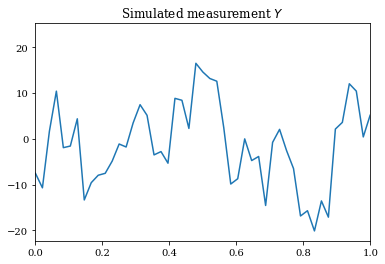

In [458]:
# Signal delay in seconds
actualPhaseShifts = np.random.uniform(size=n)
actualAmplitudes = np.random.uniform(size=n,high=maxAmplitude)
#actualAmplitudes = np.array([5.0,10.0])
actual = (actualPhaseShifts, actualAmplitudes)
noiseSTD = .6*maxAmplitude

#Y = np.interp(T[:N-delayIndex] + delay, T, X)
#Y = Xfunc(T[:N] + delay)

Y = sourceFunc(T, actualPhaseShifts, actualAmplitudes)

noise = np.random.normal(size=Y.shape, loc=0, scale=noiseSTD)
Y+= noise


plt.title("Simulated measurement $Y$")
plt.xlim(0,1)
plt.plot(T[:N],Y)

plt.show()

## Likelihood function
If we model the noise as a normal distribution, independent for each measurement point, we have:

$Y(t) \sim N(X(t,\pmb{\phi},\pmb{A}), \sigma^2)$

The goal is to determine $\pmb{\phi}$ (and $\pmb{A}$) from data.

Since the time domain is discretized, the likelihood function for a measurement $Y$ is given by:

$L(\pmb{\phi},\pmb{A}) = \prod_{i=0}^{M-1} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(\frac{1}{2 \sigma^2} (Y_i - X(i\cdot f_S,\pmb{\phi},\pmb{A}))^2\right)$

which gives us the log likelihood function:

$\log L(\pmb{\phi},\pmb{A}) = -M \log (\sqrt{2 \pi \sigma^2}) - \frac{1}{2 \sigma^2} \sum_{i=0}^{M-1} (Y_i - X(i\cdot f_S,\pmb{\phi},\pmb{A}))^2$

where $f_S$ is the sample rate of our measurement. $M$ is the correlation window (the number of usable measurement points).

In [459]:
maxShift = min(N,int(sampleFreq / max(sourceFreqs)))
correlationWindow = N - maxShift
M = correlationWindow

noiseVar = noiseSTD**2

def logLikelihood(phaseShifts,phaseAmplitudes):
    diffs = Y[:M] - sourceFunc(T[:M], phaseShifts,phaseAmplitudes)
    return -M*np.log(np.sqrt(2.0*np.pi*noiseVar)) - np.dot(diffs,diffs) / (2.0 * noiseVar)
    #return -np.dot(diffs,diffs) / (2.0 * noiseVar)
    # TODO: The correlation window should actually be as large as possible

We can find a coarse estimate for the MLE by calculating the likelihood of parameters in a regularly spaced grid, and finding the set of parameters that maximize this value.

In [460]:
%%time
# A coarse estimate
#phaseResolution = 15
#ampResolution = 20

phaseResolution = 4
ampResolution = 4


phaseShiftGrid = itertools.product(list(np.linspace(0,1,num=phaseResolution,endpoint=False)), repeat=n)
amplitudeGrid = itertools.product(list(np.linspace(0,maxAmplitude,num=ampResolution)), repeat=n)

parameterSpaceGrid = itertools.product(phaseShiftGrid,amplitudeGrid)
parameterSpaceGrid = list(parameterSpaceGrid)
def calc_ll(par):
    return logLikelihood(np.array(par[0]),np.array(par[1]))

mppool = Pool(16)
llGrid = list(mppool.map(calc_ll,parameterSpaceGrid))

MLEcoarse = parameterSpaceGrid[max(range(len(llGrid)), key=lambda i: llGrid[i])]
MLEcoarse = (np.array(MLEcoarse[0]),np.array(MLEcoarse[1]))
#MLEcoarse = max(parameterSpaceGrid, key=lambda par: logLikelihood(np.array(par[0]),np.array(par[1])))

print("coarse MLE:", MLEcoarse)
print("actual:", actual)

coarse MLE: (array([0.75, 0.5 ]), array([6.66666667, 6.66666667]))
actual: (array([0.83388271, 0.46255616]), array([5.09170858, 7.88882162]))
CPU times: user 316 ms, sys: 2.9 s, total: 3.22 s
Wall time: 1.7 s


A finer estimate minimizes the log-likelihood funtion, using the coarse estimate as an initial guess.

In [461]:
%%time
# A finer estimate
MLEcoarse_vec = np.array(list(MLEcoarse[0]) + list(MLEcoarse[1]))
# TODO: no bounds might be better when the actual phase shift is close to 0, and the MLEcoarse lands on 0.99
# parameterBounds = tuple(itertools.repeat((0.0,1.0),n))


MLE = scipy.optimize.minimize(lambda d: -logLikelihood(d[:n],d[n:]), MLEcoarse_vec).x
MLE = (MLE[:n],MLE[n:])

# Negative amplitudes correspond to a .5 phase shift:
for i in range(n):
    if MLE[1][i] < 0:
        MLE[1][i] = -MLE[1][i]
        MLE[0][i] += .5

# The found MLE for a phase shift might be outside of the [0,1] bound. Since the source function is periodic, the phase shift is mod 1.
MLE = (np.remainder(MLE[0],1.0), MLE[1])

print("fine MLE:", MLE)
print("actual MLE:", actual)

fine MLE: (array([0.79214311, 0.45336701]), array([6.07466433, 8.18217086]))
actual MLE: (array([0.83388271, 0.46255616]), array([5.09170858, 7.88882162]))
CPU times: user 4 ms, sys: 12 ms, total: 16 ms
Wall time: 13.1 ms


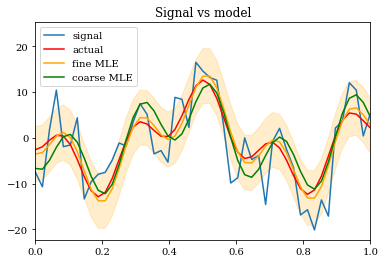

In [462]:
plt.title("Signal vs model")
plt.xlim(0,1)
plt.plot(T,Y,label="signal")
plt.plot(T,sourceFunc(T,actual[0],actual[1]),label="actual",c='r')
plt.plot(T,sourceFunc(T,MLE[0],MLE[1]),label="fine MLE",c='orange')
plt.plot(T,sourceFunc(T,MLEcoarse[0],MLEcoarse[1]),label="coarse MLE",c='g')
plt.fill_between(T,sourceFunc(T,MLE[0],MLE[1])+noiseSTD,sourceFunc(T,MLE[0],MLE[1])-noiseSTD,color='orange',alpha=.2)
plt.legend()
plt.show()

Let's plot the likelihood landscape of the parameter space. The number of dimensions of this space is $\dim(\pmb{\phi}) + \dim(\pmb{A})=2n$, which is hard to visualize for $n>1$. Since we are mostly interested in the phase shift parameter $\pmb{\phi}$, we will fix the amplitude parameters to the values found by the MLE, leaving $n$ free dimensions. For $n=1$ and $n=2$, we can plot a likelihood graph as a function of $\pmb{\phi}$.

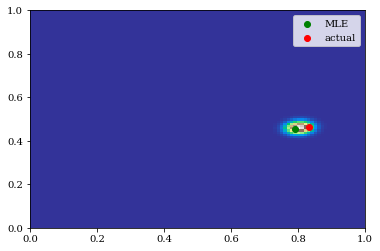

coarse MLE for phase shifts:  [0.75 0.5 ]
fine MLE for phase shifts:  [0.79214311 0.45336701]
actual phase shifts:  [0.83388271 0.46255616]
CPU times: user 1.74 s, sys: 6.86 s, total: 8.61 s
Wall time: 3.24 s


In [463]:
%%time

if n <= 2:
    phaseResolution = 100
    phaseShiftGrid = [np.array(s) for s in itertools.product(list(np.linspace(0,1,num=phaseResolution,endpoint=False)), repeat=n)]
    amplitudes = MLE[1]


    # Compute the log likelihood function for poissible shift times, given our data:
    # TODO: parallelelize

    def derp(s):
        return logLikelihood(s,amplitudes)

    mppool = Pool(16)
    dataLogLikelihood = mppool.map(derp, phaseShiftGrid)
    # Since the likelihood function is not normalized, we can translate the array to avoid taking the exp of extremely low floating point numbers.
    dataLogLikelihood = list(dataLogLikelihood)
    dataLogLikelihood -= np.max(dataLogLikelihood)
    dataLikelihood = np.exp(dataLogLikelihood)

    if n == 1:
        plt.title("log likelihood for phase shift")
        plt.plot(phaseShiftGrid, dataLogLikelihood,'-')
        plt.axvline(x=actual[0][0], color='r',linestyle="dashed",label="actual")
        plt.axvline(x=MLE[0][0], color='g',label="fine MLE")
        plt.legend()
        plt.show()
        
        phaseShiftGridPrecise = [np.array([z]) for z in np.linspace(MLE[0][0] - .1, MLE[0][0] + .1, num=100)]
        dataLogLikelihoodPrecise = [logLikelihood(shifts,amplitudes) for shifts in phaseShiftGridPrecise]
        dataLogLikelihoodPrecise -= np.max(dataLogLikelihoodPrecise)
        dataLikelihoodPrecise = np.exp(dataLogLikelihoodPrecise)

        plt.title("likelihood for phase shift")
        plt.xlim(MLE[0][0] - .1, MLE[0][0] + .1)
        plt.ylim(0,1)
        plt.plot(phaseShiftGrid, dataLikelihood,'b.',label="integer shifts")
        plt.plot(phaseShiftGridPrecise, dataLikelihoodPrecise,'y-',label="precise shifts")
        plt.axvline(x=actual[0][0], color='r',linestyle="dashed",label="actual")
        plt.axvline(x=MLE[0][0], color='g',label="fine MLE")
        plt.legend()
        plt.show()
    elif n==2:
        xAxis = np.linspace(0,1,num=phaseResolution)
        yAxis = np.linspace(0,1,num=phaseResolution)
        colorData = np.zeros((phaseResolution,phaseResolution))
        for i,c in enumerate(dataLikelihood):
            colorData[i%phaseResolution, i//phaseResolution] = c
        plt.pcolormesh(xAxis,yAxis,colorData, cmap=plt.get_cmap('terrain'))
        plt.scatter(*(MLE[0]),color='g',label='MLE')
        plt.scatter(*actualPhaseShifts,color='r',label='actual')
        plt.legend()
        plt.show()

print("coarse MLE for phase shifts: ",MLEcoarse[0])
print("fine MLE for phase shifts: ",MLE[0])
print("actual phase shifts: ",actual[0])


# Discussion
- The assumption that the noise of each measurement point is independently distributed, is probably incorrect.
- The variance of noise should be determined from data.
- I should use the built-in basin hopping function in the scipy package.